# <center> Model for Spam filteration using SVM, Decision Tree Classifier and Random Forest Classifier </center>

## Importing Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re 
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

## Loading Dataset

In [4]:
# List of potential encodings to try
encodings = ['utf-8', 'latin-1', 'ISO-8859-1']

# Try reading the file with different encodings
for encoding in encodings:
    try:
        data = pd.read_csv(r'spam.csv', encoding=encoding)
        print(f"File successfully read with encoding: {encoding}")
        break  # Break out of the loop if successful
    except UnicodeDecodeError:
        print(f"Failed to read with encoding: {encoding}")

# If none of the encodings work, you may need to investigate the file further


Failed to read with encoding: utf-8
File successfully read with encoding: latin-1


In [5]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)

In [7]:
data

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Data Preprocessing

In [8]:
data.columns = ['kind', 'message']

In [9]:
data

,kind,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [10]:
data.describe()

,kind,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   kind     5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [12]:
data.isnull().sum()

kind       0
message    0
dtype: int64

In [13]:
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

stop_words = set(stopwords.words('english'))
stemmer = LancasterStemmer()

def cleaning_data(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'.pic|S+', '', text)
    text = re.sub(r'[^a-zA-Z+]', ' ', text)
    text = "".join([i for i in text if i not in string.punctuation])
    
    words = nltk.word_tokenize(text)
    words = [i for i in words if i not in stop_words and len(i) > 2]
    
    text = " ".join(words)
    text = re.sub(r'\s+', " ", text).strip()
    
    return text

data['CleanMessage'] = data['message'].apply(cleaning_data)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   kind          5572 non-null   object
 1   message       5572 non-null   object
 2   CleanMessage  5572 non-null   object
dtypes: object(3)
memory usage: 130.7+ KB


In [15]:
data

,kind,message,CleanMessage
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts may te...
3,ham,U dun say so early hor... U c already then say...,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,time tried contact pound prize claim easy call...
5568,ham,Will Ì_ b going to esplanade fr home?,going esplanade home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood suggestions
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching acted like interested buying some...


In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['CleanMessage'])

# one hot encoder for kind 
encoder = OneHotEncoder(sparse = False, drop = 'first')
Y = encoder.fit_transform(data['kind'].values.reshape(-1, 1))
X_combined = np.hstack((X.toarray(), Y))

print(X_combined)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## EDA

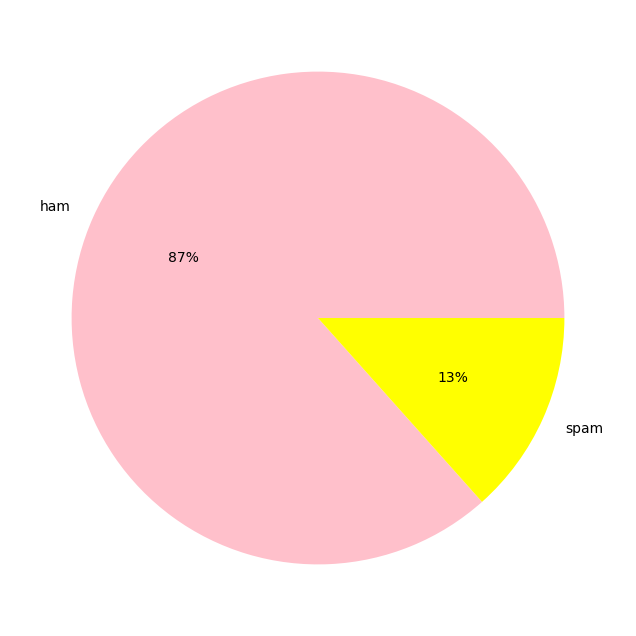

In [17]:
plt.figure(figsize = (8, 8))
kind_counts = data['kind'].value_counts()
colors = ['pink', 'yellow']
plt.pie(kind_counts, labels = kind_counts.index, autopct = '%0.0f%%', colors=colors)
plt.show()

## Model Building

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#### SVM

In [19]:
parameters = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [100, 50]
}

svm_rs = RandomizedSearchCV(SVC(), param_distributions = parameters, cv = 3, random_state = 42)
svm_rs.fit(x_train, y_train)

y_pred_svm = svm_rs.predict(x_test)

In [20]:
svm_accuracy = accuracy_score(y_true = y_test, y_pred = y_pred_svm)

In [21]:
print("The accuracy score of SVM Model is: ", svm_accuracy)

The accuracy score of SVM Model is:  0.9730941704035875


#### Decision Tree Classifier

In [22]:
parameters = {'max_depth': np.arange(2, 10, 2)}

dt_classifier = DecisionTreeClassifier()
dt_classifier_rs = RandomizedSearchCV(dt_classifier, param_distributions = parameters, random_state = 42)
dt_classifier_rs.fit(x_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'max_depth': array([2, 4, 6, 8])},
                   random_state=42)

In [23]:
y_pred_dt = dt_classifier_rs.predict(x_test)

In [24]:
dt_accuracy = accuracy_score(y_true = y_test, y_pred = y_pred_dt)
print('Accuracy using Decision Tree: ', dt_accuracy)

Accuracy using Decision Tree:  0.9650224215246637


#### Random Forest Classifier

In [25]:
parameters = {
    'n_estimators': np.arange(20, 101, 10),
    'max_depth': np.arange(2, 17, 2)
}

rf_classifier = RandomForestClassifier()
rf_classifier_rs = RandomizedSearchCV(rf_classifier, param_distributions = parameters, random_state = 42)
rf_classifier_rs.fit(x_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16]),
                                        'n_estimators': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100])},
                   random_state=42)

In [26]:
y_pred_rf = dt_classifier_rs.predict(x_test)

In [27]:
dt_accuracy = accuracy_score(y_true = y_test, y_pred = y_pred_rf)
print('Accuracy using Random Forest Classifier is: ', dt_accuracy)

Accuracy using Random Forest Classifier is:  0.9650224215246637
